<a href="https://colab.research.google.com/github/cwscx/makmore/blob/main/build_makemore_mlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# from google.colab import files
# uploaded = files.upload()

Saving names.txt to names.txt


In [16]:
words: list[str] = open('names.txt', 'r').read().splitlines()

In [5]:
stoi: dict[str, int] = {c:i for i, c in enumerate('.abcdefghijklmnopqrstuvwxyz')}
itos: dict[int, str] = {i:c for c, i in stoi.items()}

In [6]:
block_size = 3

def build_dataset(words: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
  inputs_list: list[list[int]] = []
  labels_list: list[int] = []

  for w in words:
    inputs: list[int] = [0] * block_size
    for c in w + '.':
      index: int = stoi[c]
      inputs_list.append(inputs)
      labels_list.append(index)
      inputs = inputs[1:] + [index]

  return torch.tensor(inputs_list), torch.tensor(labels_list)

import random
random.seed(42)
random.shuffle(words)
threshold1: int = int(0.8 * len(words))
threshold2: int = int(0.9 * len(words))

training_x, training_y = build_dataset(words[:threshold1])
validation_x, validation_y = build_dataset(words[threshold1:threshold2])
test_x, test_y = build_dataset(words[threshold2:])


In [7]:
g = torch.Generator().manual_seed(2147483647)

vocab_size = len(itos)
embedding = 10
hidden = 200

C = torch.randn((vocab_size, embedding), generator=g)
W1 = torch.randn((block_size * embedding, hidden), generator=g) * (5/3) / (block_size * embedding)**0.5 # 0.2
b1 = torch.randn((hidden), generator=g) * 0.01
W2 = torch.randn((hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# we want initial pre-activation to be normal distributed, but long term we
# want them to evolve themselves. The following tensor will "scale and shift"
# batch_norm_gain * xx + batch_norm_bias. Technically it does nothing. But
# during back propagation, those two tensors will learn and shift themselves
# to not follow exactly normal distribution.
#
# the negative part is that this will introduce relationship/dependency of
# data within a random batch (in our case 32 words), and make the words
# related to each other in the vector representation. distort the feature
# embedding.
#
# but on the other side it introduces such noices help the nn to avoid overfit.
batch_norm_gain = torch.ones((1, hidden))
batch_norm_bias = torch.zeros((1, hidden))
batch_norm_mean_running = torch.zeros((1, hidden))
batch_norm_std_rnning = torch.ones((1, hidden))

parameters = [C, W1, b1, W2, b2, batch_norm_gain, batch_norm_bias]

for p in parameters:
  p.requires_grad = True

In [8]:
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):
  batches = torch.randint(0, high=len(training_x), size=(batch_size,), generator=g)
  training_x_batch = training_x[batches]
  training_y_batch = training_y[batches]
  embedding = C[training_x_batch]
  h1 = embedding.view(embedding.shape[0], -1) @ W1 + b1
  batch_norm_mean = h1.mean(0, keepdim=True)
  batch_norm_std = h1.std(0, keepdim=True)
  h2 = batch_norm_gain * (h1 - batch_norm_mean) /batch_norm_std  + batch_norm_bias

  with torch.no_grad():
    batch_norm_mean_running = 0.999 * batch_norm_mean_running + 0.001 * batch_norm_mean
    batch_norm_std_rnning = 0.999 * batch_norm_std_rnning + 0.001 * batch_norm_std

  # d tanh / dx = (1 - t**2) * out_grad.
  # t = (e^2x - 1) / (e^2x + 1)
  # if t = 1 or -1 or close, the grad will become almost 0.
  h3 = torch.tanh(h2)
  logits = h3 @ W2 + b2
  loss = F.cross_entropy(logits, training_y_batch)

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if i < max_steps / 2 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [183]:
-torch.tensor(1/27.0).log() # expected negative log possibility

tensor(3.2958)

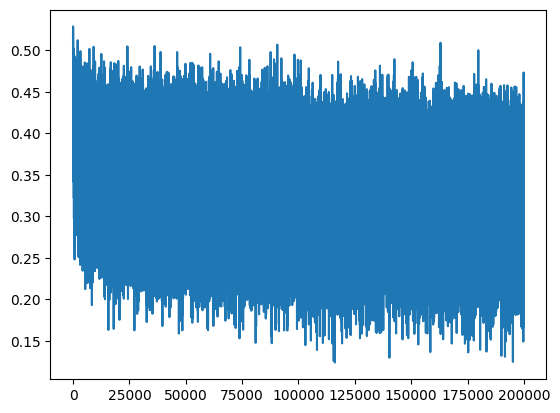

In [12]:
plt.plot(losses)

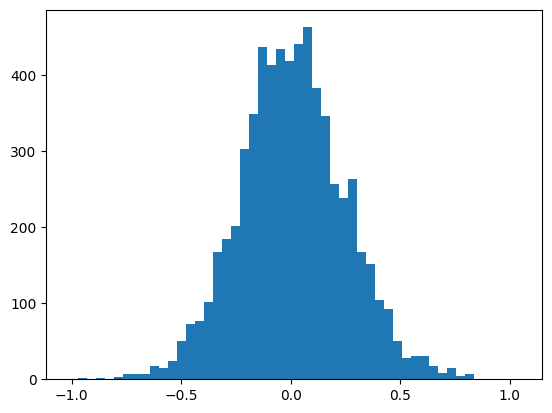

In [212]:
plt.hist(h1.view(-1).tolist(), 50);

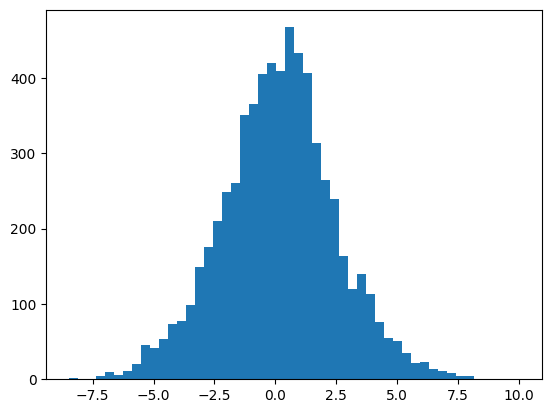

In [14]:
plt.hist(h1.view(-1).tolist(), 50);

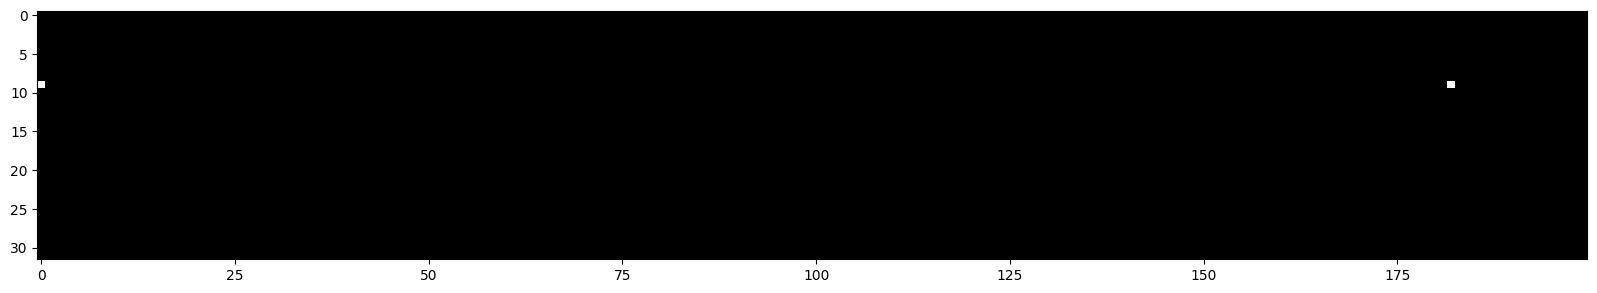

In [214]:
plt.figure(figsize=(20, 10))
# white is true. black is false.
plt.imshow(h1.abs() > 0.99, cmap="gray", interpolation="nearest")

In [10]:
with torch.no_grad():
  emb = C[training_x]
  h = emb.view(emb.shape[0], -1) @ W1 + b1
  batch_normalization_mean = h.mean(0, keepdim=True)
  batch_normalizatino_std = h.std(0, keepdim=True)


In [11]:
@torch.no_grad() # disable gradient tracking to make method faster.
def split_loss(split):
  x, y = {
      'train': (training_x, training_y),
      'val': (validation_x, validation_y),
      'test': (test_x, test_y),
  }[split]
  embedding = C[x]
  h1 = embedding.view(embedding.shape[0], -1) @ W1 + b1
  h2 = batch_norm_gain * (h1 - batch_normalization_mean) / batch_normalizatino_std + batch_norm_bias

  # d tanh / dx = (1 - t**2) * out_grad.
  # t = (e^2x - 1) / (e^2x + 1)
  # if t = 1 or -1 or close, the grad will become almost 0.
  h3 = torch.tanh(h2)
  logits = h3 @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('val')
split_loss('test')

val 2.104926824569702
test 2.106419086456299


In [154]:
g = torch.Generator().manual_seed(2147483647 + 10)

for i in range(20):
  out = []
  inputs = [0] * block_size

  while True:
    h = torch.tanh(C[torch.tensor(inputs)].view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    index = torch.multinomial(probs, num_samples=1, generator=g).item()
    inputs = inputs[1:] + [index]
    out.append(index)
    if (index == 0):
      break

  print(''.join(itos[i] for i in out))

carman.
amille.
khyrmyn.
reet.
khalayane.
mahnen.
deliah.
jareei.
nellara.
chaiivon.
legen.
ham.
jorn.
quintin.
lilea.
jadiquinterri.
jarysia.
kael.
dustine.
deciia.


<Axes: >

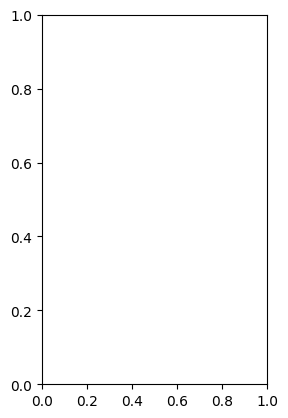

In [17]:
 x = torch.randn(1000, 10)
 w = torch.randn(10, 200) / 10**0.5
 y = x @ w

# if standard deviation is too large. There will be some really large number
# that will cause activation function to be really big, and cause lost gradient.
 print(x.mean(), x.std())
 print(y.mean(), y.std())

 plt.figure(figsize=(20, 5))
 plt.subplot(121)
 plt.hist(x.view(-1).tolist(), 50, density=True)
 plt.subplot(122)
 plt.hist(y.view(-1).tolist(), 50, density=True)

In [103]:

class Linear:

  def __init__(self, fan_in: int, fan_out: int, bias: bool=True) -> None:
    self.weight: torch.Tensor = torch.randn((fan_in, fan_out), generator=g) # / fan_in ** 0.5
    self.bias: torch.Tensor | None = torch.zeros(fan_out) if bias else None

  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    self.out: torch.Tensor = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim: int, eps: float=1e-5, momentum: float=0.1) -> None:
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters.
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    if (self.training):
      x_mean = x.mean(0, keepdim=True)
      x_var = x.var(0, keepdim=True, unbiased=True)
    else:
      x_mean = self.running_mean
      x_var = self.running_var

    standardized_x = (x - x_mean) / torch.sqrt(x_var - self.eps)
    self.out = self.gamma * standardized_x + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return [self.gamma, self.beta]

class Tanh:

  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    self.out = torch.tanh(x)
    return self.out

  def parameters(self) -> list[torch.Tensor]:
    return []

n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),             BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),             BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),             BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden),             BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),           BatchNorm1d(vocab_size)
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  # for layer in layers[: -1]:
  #   if isinstance(layer, Linear):
  #     layer.weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
  p.requires_grad = True


47551


In [104]:
max_steps = 200000
batch_size = 32
losses = []
ud = []

for i in range(max_steps):

  indexes = torch.randint(0, training_x.shape[0], (batch_size, ), generator=g)
  batch_x = training_x[indexes]
  batch_y = training_y[indexes]

  embedding = C[batch_x]
  x = embedding.view(embedding.shape[0], -1)
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, batch_y)

  for layer in layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad = None

  loss.backward()

  lr = 0.1 if i < max_steps / 2 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())
  with torch.no_grad():
    ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

  if i >1000:
    break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.94%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.50%
layer 8 (      Tanh): mean -0.00, std 0.63, saturated: 2.91%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.81%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.53%


Text(0.5, 1.0, 'activation distribution')

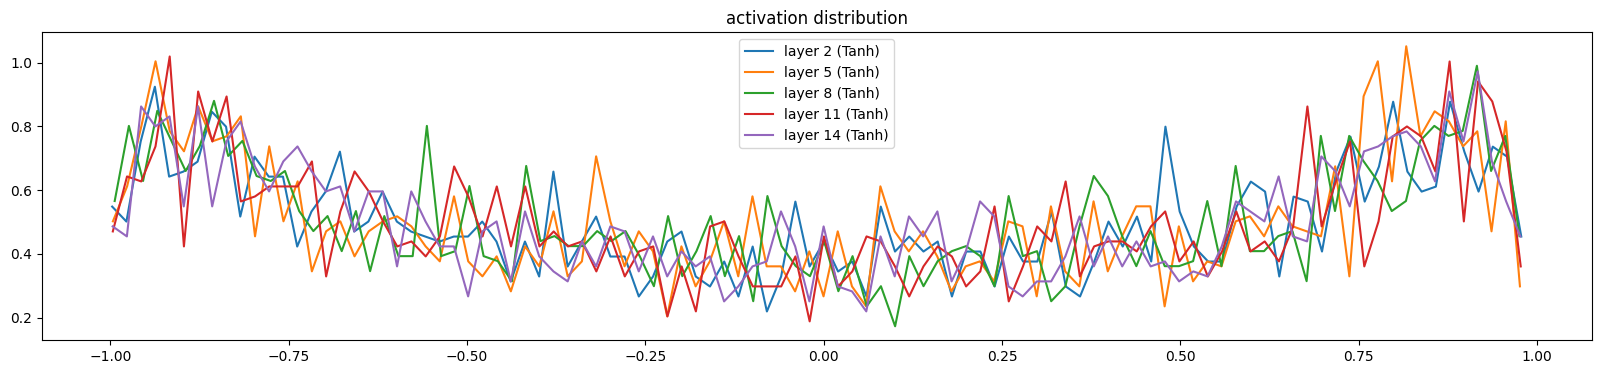

In [105]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (
        i, layer.__class__.__name__, t.mean(), t.std(),
        (t.abs() > 0.97).float().mean() * 100
    ))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00
layer 5 (      Tanh): mean +0.00, std 0.00
layer 8 (      Tanh): mean -0.00, std 0.00
layer 11 (      Tanh): mean +0.00, std 0.00
layer 14 (      Tanh): mean +0.00, std 0.00


Text(0.5, 1.0, 'gradient distribution')

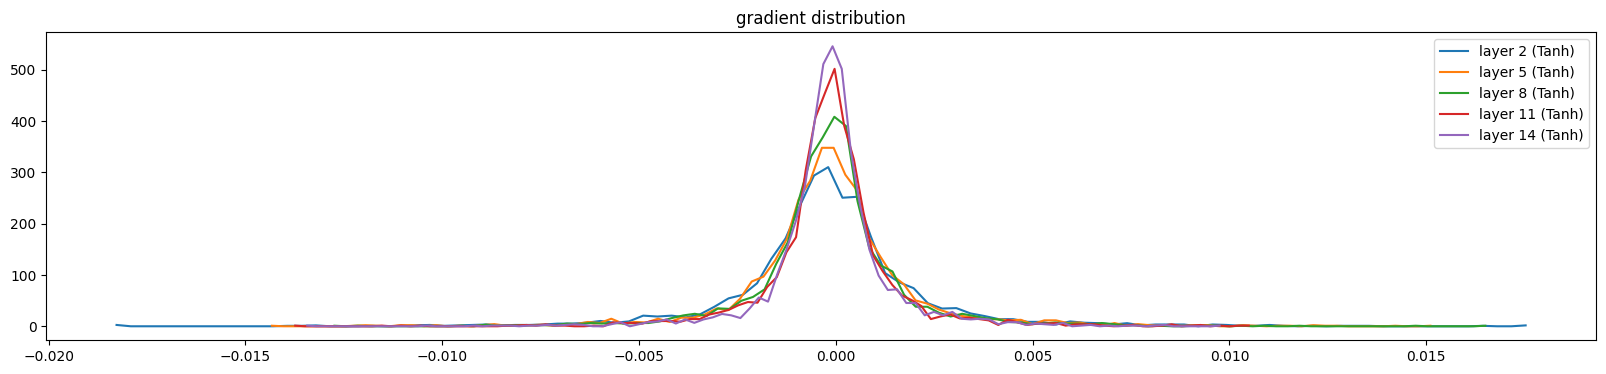

In [106]:
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f' % (
        i, layer.__class__.__name__, t.mean(), t.std()
    ))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 6.678288e-03 | grad:data ratio 6.672542e-03
weight  (30, 100) | mean -0.000017 | std 1.885461e-03 | grad:data ratio 1.839667e-03
weight (100, 100) | mean -0.000024 | std 9.404821e-04 | grad:data ratio 9.435719e-04
weight (100, 100) | mean +0.000004 | std 7.932298e-04 | grad:data ratio 7.874757e-04
weight (100, 100) | mean -0.000001 | std 6.953318e-04 | grad:data ratio 6.931889e-04
weight (100, 100) | mean -0.000002 | std 6.379079e-04 | grad:data ratio 6.353266e-04
weight  (100, 27) | mean -0.000023 | std 1.019904e-03 | grad:data ratio 1.031552e-03


Text(0.5, 1.0, 'weights gradient distribution')

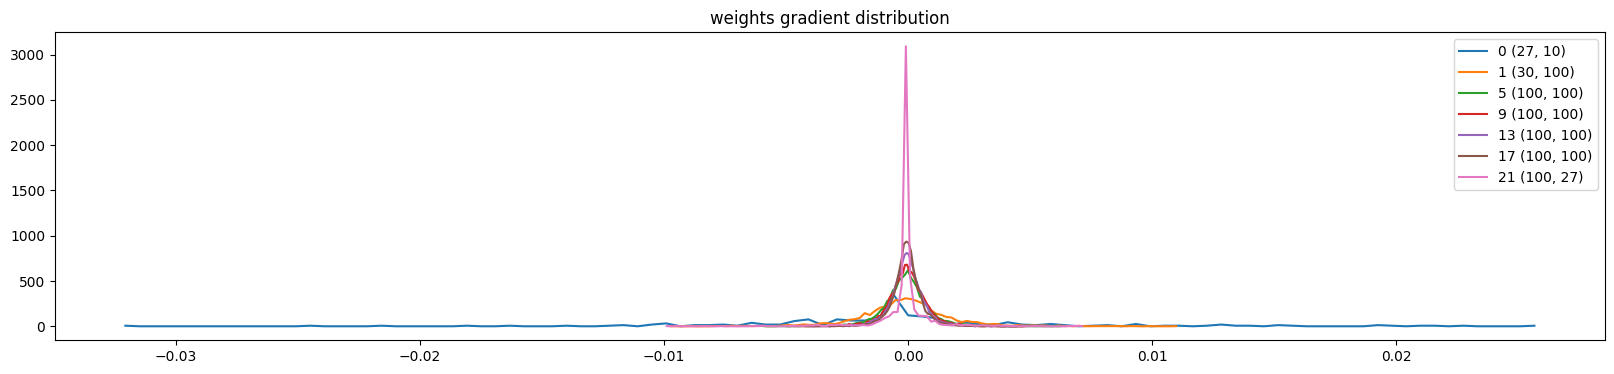

In [107]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (
        tuple(p.shape), t.mean(), t.std(), t.std() / p.std()
    ))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution')

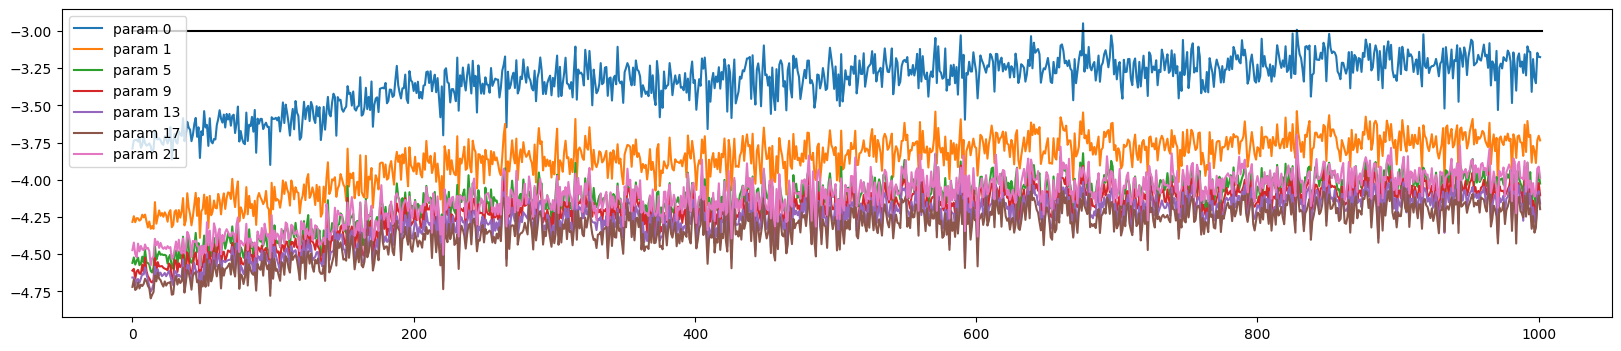

In [108]:
plt.figure(figsize=(20, 4))
legends = []

for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)

In [ ]:
@torch.no_grad() # disable gradient tracking to make method faster.
def split_loss(split):
  x, y = {
      'train': (training_x, training_y),
      'val': (validation_x, validation_y),
      'test': (test_x, test_y),
  }[split]
  embedding = C[x]
  input = embedding.view(embedding.shape[0], -1)
  for layer in layers:
    input = layer(input)
  loss = F.cross_entropy(input, y)

  print(split, loss.item())

for layer in layers:
  layer.training = False

split_loss('val')
split_loss('test')